<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/Barrages/SimulEbbGeneration_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from typing import Callable, List, Tuple
from dataclasses import dataclass, field
import matplotlib.pyplot as mpl
import numpy as np
import pathlib, os
import numpy.typing as npt

try:
  from tqdm.notebook import tqdm
except ModuleNotFoundError:
  !pip install tdqm
  from tqdm.notebook import tqdm

If running python on Windows operating system, copy the file

https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py

to the working folder before running the notebook.

In [35]:
if not pathlib.Path("mpl_utils.py").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
mut.config_plots()

mpl.rcParams["figure.figsize"] = (12, 3)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-35-0d7805b32f05>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Algebraic models

## Barrage simulator in ebb mode

The following models were implemented to simulate the tidal power plant:

* The basin
* The tide
* Hydraulic turbines
* Electrical generators
* Sluice gates
* Power plant controller

## Turbine hill map and turbine operating curve

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/TurbineGeneratorMaps/TurbineHill_Plot.svg" width="500px" style="display:inline">


### Turbine mode

Turbine dimensionless numbers

* Rotational speed $$n_{11}=\dfrac{\Omega D}{\sqrt{gh}}.$$

* Flow rate $$Q_{11} = \dfrac{Q}{D^2\sqrt{gh}}.$$

* Efficiency $$\eta_\mathrm{turb} = \dfrac{P_\mathrm{turb}}{P_\mathrm{avail}}.$$


The power available to the turbine is given by

$$P_\mathrm{avail} = \rho g h Q,$$

where

$$Q = D^2 \sqrt{gh} \, Q_{11}\!\big( n_{11} \big).$$

The turbine is to be operated at constant rotational speed due to the use of a synchronous generator (see generator class).

The available energy is

$$\dfrac{\text{d} E_\text{avail}}{\text{d}t} = P_\text{avail}.$$

The energy harvest by the turbine is

$$\dfrac{\text{d} E_\text{turb}}{\text{d}t}=\eta_\text{turb}\big( n_{11}\big) \, P_\text{avail},$$

The mean turbine efficiency is

$$\overline{\eta_\text{turb}} = \dfrac{E_\text{turb}}{E_\text{avail}}.$$

### Sluicing mode

The in sluicing mode the "turbine" is modelled as

$$Q_\mathrm{turb}^\mathrm{sluice} = C_\mathrm{d} A_\mathrm{turb} \sqrt{ 2 g h }$$

where $A_\mathrm{turb}$ is the area corresponding to the turbine rotor diameter.



In [36]:
@dataclass
class TurbineModel:

  # flow rate: efficiency: red line of the map
  poly_CQ1: np.poly1d = np.poly1d( np.array([0.16928201, 0.08989368]) )

  # flow rate: green line of the map
  poly_CQ2: np.poly1d = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03,
                                         -9.25873626e-02,  1.75687197e+00]) )

  # efficiency: red line of the map
  poly_CE1: np.poly1d = np.poly1d( np.array([-0.02076456, 0.20238444,
                                              0.48984553]) )
  # efficiency: green line of the map
  poly_CE2: np.poly1d = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,
                                             6.86081825e-04,  7.93083108e-01]) )

  # n11 interpolation domain
  n11_min: float =  4.38  # [-]
  n11_max: float = 17.17  # [-]

  # other data
  ga: float = 9.8         # [m/s²] gravity aceleration
  ρw: float = 1025.0      # kg/m³] water density
  CD_sluice: float = field(init=False) # [-] sluice mode discharge coefficient

  #=============================================================================
  def __init__( self, D_turb, Omega, CD_sluice ) -> None:

    self.Omega = Omega    # we are assuming constant rotational speed model
    self.D_turb = D_turb  # turbine rotor diameter
    self.A_turb = np.pi*(D_turb/2.0)**2

    # constants used in for computing n11 and QT
    self.CT0 = Omega * D_turb / np.sqrt( self.ga )
    self.CT1 = D_turb**2 * np.sqrt( self.ga )

    self.CD_sluice = CD_sluice

  def n11_range( self ) -> tuple:
    return ( self.n11_min, self.n11_max )

  # dimensionless velocity
  def n11( self, h: float ) -> float:
    # avoid division by zero on h = 0.0
    return self.CT0 / np.sqrt( max( h, 1E-3 ) )

  # dimensionless flow rate
  def Q11( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < 7.92193:
      return self.poly_CQ1( n11 )
    else:
      return self.poly_CQ2( n11 )

  # efficiency
  def eta( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < 7.92193:
      return self.poly_CE1( n11 ) * 0.912
    else:
      return self.poly_CE2( n11 ) * 0.912

  # computing operational data
  def operating_point( self, h: float ) -> Tuple[float,float,float]:
    n11 = self.n11( h )
    QT = self.CT1 * self.Q11( n11 ) * np.sqrt( h )
    PH = self.ρw * self.ga * h * QT
    ηT = self.eta( n11 )
    return QT, PH, ηT

  # turbine flow rate in sluice mode
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.A_turb * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Generator efficiency curve

The electrical generator is assumed to be a synchronous machine. The rotational speed is given by

$$\Omega = \dfrac{2\pi f}{p}$$

where $f$ is the electrical grid frequency and $p$ is the number of pairs of poles.

<br />

The generator efficiency is computed as a function of the load

$$\Lambda = \dfrac{P_\mathrm{turb}}{P_\mathrm{gen}^\mathrm{rated}}$$


<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/TurbineGeneratorMaps/GeneratorEff_plot.svg" width="400px" style="display:inline">

Electrical power output is

$$P_\mathrm{gen} =\eta_\mathrm{gen}(\Lambda) \, P_\mathrm{turb},$$

and the converted energy is

$$\dfrac{\mathrm{d} E_\mathrm{gen}}{\mathrm{d} t} = P_\mathrm{gen}.$$

The mean generator efficiency is

$$\overline{\eta_\mathrm{gen}}=\dfrac{E_\mathrm{gen}}{E_\mathrm{turb}}.$$



In [37]:
@dataclass
class GeneratorModel:

  # red part of the curve
  poly_C1: np.poly1d = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03,
                                            -3.80834059e+02,  2.70423225e+01,
                                             3.29394948e-03]) )
  # green part of the curve
  poly_C2: np.poly1d = np.poly1d( np.array([-1.16856952,  3.31172525,
                                            -3.44296217,  1.5416029 ,
                                             0.71040716]) )

  Pgen_rated: float = field(init=False) # [W] Generator rate power

  #=============================================================================
  def __init__( self, Pgen_rated: float ) -> None:
    self.Pgen_rated = Pgen_rated

  # efficiency as a function of the load
  def eta( self, Pturb: float ) -> float:
    load = Pturb / self.Pgen_rated

    assert( load >= 0.0 ), "turbine power lower than zero"
    assert( load <= 1.0 ), "generator rated power to low (%f)" % Pturb
    if load < 0.12542:
      return self.poly_C1( load )
    else:
      return self.poly_C2( load )

## Sluice gates

The sluice gates are modelled as a turbulent pressure drop

$$Q_\mathrm{sluice} = C_\mathrm{d} A \sqrt{ 2 g h }$$

typical discharge coefficients for barrage sluice gates are within the range $0.8 \le C_\mathrm{d} \le 1.2$. Here we use $C_\mathrm{d}=1.0$.

In [38]:
@dataclass
class GateModel:
  ga: float = 9.8                       # [m/s²]
  CD_sluice: float = field(init=False)  # [-]

  #=============================================================================
  def __init__( self, Area: float, CD_sluice ) -> None:
    self.Area = Area
    self.CD_sluice = CD_sluice

  # flow rate as a function of h
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.Area * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Tide modelling

The tide level is assumed to be a trignometric series

$$\zeta(t) = \sum_i^n A_i \cos\left( \omega_i t + \phi_i \right).$$

In [39]:
@dataclass
class TideModel:

  # A_tide, period and φ_tide are vectors to allow simulate multi-component tides
  def __init__( self, A_tide: npt.NDArray, ω_tide: npt.NDArray, φ_tide:npt.NDArray ) -> None:
      self.A_tide = A_tide
      self.ω_tide = ω_tide
      self.φ_tide = φ_tide

  # tide level as a function t
  def level( self, t: float ) -> npt.NDArray:
      return np.sum( self.A_tide * np.cos( self.ω_tide * t + self.φ_tide ) )

## Basin modelling


<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/BasinShoeBox_MWL.svg" width="300px" style="display:inline">


<br/>


The instantaneous basin volume is computed from

$$\dfrac{\mathrm{d}V}{\mathrm{d}t}=-Q(t).$$

The out flow is denoted as positive.

<br />

Let $z(t)$ be the water level with respect to the mean water level (MWL) and $A_\mathrm{basin}(z)$ the basin area as a function of $z(t)$.

<br />

Knowing that $V=z \, A_\mathrm{basin}(z)$, the basin volume change as function of time is computed as

$$
\dfrac{\mathrm{d}V}{\mathrm{d}t}
=\dfrac{\mathrm{d}(z \, A_\mathrm{basin}(z))}{\mathrm{d}t}
=\dfrac{\mathrm{d}z}{\mathrm{d}t}A_\mathrm{basin}(z) + z\,\dfrac{A_\mathrm{basin}(z)}{\mathrm{d}z}\dfrac{\mathrm{d}z}{\mathrm{d}t}
= f_\mathrm{basin}(z)\dfrac{\mathrm{d}z}{\mathrm{d}t}
$$

where

$$f_\mathrm{basin}(z)=A_\mathrm{basin}(z) + z\,\dfrac{A_\mathrm{basin}(z)}{\mathrm{d}z},$$

giving

$$\dfrac{\mathrm{d}z}{\mathrm{d}t}=-\frac{Q(t)}{f_\mathrm{basin}(z)}.$$

<br/>

Integrating with the Euler method in $\Delta t$, we get

$$z(t+\Delta t)=z(t) + \Delta t\,\left(-\frac{Q(t)}{f_\mathrm{basin}(z(t))}\right).$$


## Power plant operation model

The power plant modelling and control is based in the following finite state machine

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/BarrageEbbMode.svg" width="700px" style="display:inline">

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/EbbOperation_FSM.svg" width="700px" style="display:inline">

## Variables used in the simulation

$$ \mathbf{x} =
\begin{pmatrix} z & E_\mathrm{avail} & E_\mathrm{turb} & E_\mathrm{gen} \end{pmatrix}^\mathrm{T} $$

## Outputs

$$ \mathbf{y} =
\begin{pmatrix} h & \zeta & Q_\mathrm{turb} & Q_\mathrm{sluice} &
P_\mathrm{avail} & P_\mathrm{turb} & P_\mathrm{gen} &
\eta_\mathrm{turb} & \eta_\mathrm{gen} \end{pmatrix}^\mathrm{T} $$

# Finite State Machine simulator

In [58]:
class FSM_simulator:

  func_state = Callable[ [ float, float, npt.NDArray ], Tuple ]
  func_transition = Callable[ [ float, npt.NDArray, npt.NDArray ], int ]

  def __init__( self, simul_time: float, Delta_t: float, n_SS_vars: int, n_SS_outs: int ) -> None:
    self.dic_states = {}
    self.dic_transitions = {}

    self.n_time = int( simul_time / Delta_t) + 1
    self.n_time = self.n_time
    self.n_SS_vars = n_SS_vars
    self.n_SS_outs = n_SS_outs

    self.time = np.linspace( 0, simul_time, self.n_time )
    self.delta_t = self.time[1]

    self.SS_vars = np.zeros( (n_SS_vars, self.n_time) )
    self.SS_outs = np.zeros( (n_SS_outs, self.n_time) )
    self.FSM_states = np.zeros( self.n_time )

  def run_simulator( self, FSM_state: int, SS_vars: npt.NDArray ) -> Tuple:
    self.SS_vars[:,0] = SS_vars
    self.FSM_states[0] = FSM_state
    # outs not available at t=0

    for i in range( 1, self.n_time ):
      SS_vars, SS_outs = self.__run_state( FSM_state, self.delta_t, self.time[i-1], SS_vars )
      FSM_state = self.__test_transitions( FSM_state, self.time[i-1], SS_vars, SS_outs )

      self.SS_vars[:,i] = SS_vars
      self.SS_outs[:,i] = SS_outs
      self.FSM_states[i] = FSM_state

    return ( self.time, self.FSM_states, self.SS_vars, self.SS_outs )


  def set_state( self, state: int, func: func_state ) -> None:
    assert state not in self.dic_states.keys(), "state already define"
    self.dic_states[state] = func


  def add_transition( self, state: int, func: func_transition ) -> None:
    if state not in self.dic_transitions.keys():
      self.dic_transitions[state] = [ func ]
    else:
      self.dic_transitions[state].append( func )


  # private member
  def __run_state( self, state: int, delta_t: float, t: float, vars: npt.NDArray ) -> List:
    return self.dic_states[ state ]( delta_t, t, vars )


  # private member
  def __test_transitions( self, state: int, t: float, vars: npt.NDArray, outs: npt.NDArray ) -> int:
    for transition in self.dic_transitions[ state ]:
      new_state = transition( t, vars, outs )
      if new_state != state:
        return new_state # first transition that changes the state
    return state

# Configuration class

All config data is stored in this class

In [59]:
@dataclass
class Config:

    #===========================================================================
    # turbine data
    n_turbs: int = 20           # [-] number of turbines
    Dturb: float = 7.5          # [m] turbine diameter
    turb_CD: float = 1.0        # [-] turbine discharge coeff as sluice gate
    Omega: float = field(init=False) # [rad/s] synchronous rotational speed

    #===========================================================================
    # generator data
    grid_freq: float = 50.0     # [Hz] electrical grid frequency
    ppoles: int = 64            # [-]  Number of pole pairs of the generator
    Pgen_rated: float = 26.6E6    # [W]  generator rated power

    #===========================================================================
    # sluice gates data
    n_gates: int = 30            # [-]  number of sluice gates
    Agates: float = 10.0*15.0   # [m²] sluice gates area
    sluice_CD: float = 0.65      # [-]  sluice gates discharge coeff

    #===========================================================================
    # coeffs of the quadratic polynomial that describes the basin area
    # [ a, b, c ] => a*z**2 + b*z + c
    basin_coeffs = np.array( [ -7.93E4, 1.26E6, 2.49E7 ] )

    basin_z0 = 1.0              # [m] initial basin level

    #===========================================================================
    # tide components
    A: npt.NDArray = np.array( [ 3.31, 1.21 ] )               # [m] amplitudes
    ω: npt.NDArray = np.array( [ 2.0*np.pi/(12.42*3600), 2.0*np.pi/(12.6584*3600) ] ) # [rad/s] frequencies
    φ: npt.NDArray = np.array( [ -1.4, -2.5 ] )            # [rad] phases
    global_period: float = field(init=False) # [s] simulations' repetition period

    #===========================================================================
    delta_t = 100.0   # [s] integration time step
    simul_time: float = field(init=False) # [s]

    #===========================================================================
    # state-space config - number of variables and outputs
    # DO NOT CHANGE!
    n_SS_vars = 4
    n_SS_outs = 9

    #===========================================================================
    def __init__( self ):

      self.Omega = 2 * np.pi * self.grid_freq / self.ppoles

      if len( self.ω ) == 2:
        self.global_period = 1.0 / np.abs( np.max( self.ω[1] ) \
                                 - np.min( self.ω[0] ) ) * 2.0*np.pi
      else:
        self.global_period = 1.0 / self.ω[0] * 2.0*np.pi

      self.simul_time = 4.0*self.global_period

    ## HELPER FUNCTION #########################################################
    # minimum turbine head that starts turbine generation
    def turbine_starting_head( self, t: float ) -> float:
      return 4.2

In [60]:
@dataclass
class Models:

    #===========================================================================
    # declare a type alias for a function of a z that returns a float
    z_func = Callable[ [ float ], float ]

    #===========================================================================
    Omega: float = field(init=False)    # [rad/s] synchronous rotational speed
    n11_max: float = field(init=False)  # [-] used in the transitions
    n_turbs: float = field(init=False)  # [-]
    n_gates: float = field(init=False)  # [-]

    #===========================================================================
    # component models
    turbine: TurbineModel = field(init=False)
    generator: GeneratorModel = field(init=False)

    gate: GateModel = field(init=False)
    tide: TideModel = field(init=False)

    #===========================================================================
    # basin data
    basin_Area: np.poly1d = field( init = False )
    basin_dArea_dz: np.poly1d = field( init = False )

    #===========================================================================
    turbine_starting_head: z_func = field( init = False )

    #===========================================================================
    def __init__( self, cfg: Config ) -> None:

      self.n_turbs = cfg.n_turbs
      self.n_gates = cfg.n_gates

      self.turbine = TurbineModel( cfg.Dturb, cfg.Omega, cfg.turb_CD )
      self.generator = GeneratorModel( Pgen_rated = cfg.Pgen_rated )

      _, self.n11_max = self.turbine.n11_range()

      self.gate = GateModel( cfg.Agates, cfg.sluice_CD )
      self.tide = TideModel( cfg.A, cfg.ω, cfg.φ )

      self.basin_Area = np.poly1d( cfg.basin_coeffs )
      self.basin_dArea_dz = self.basin_Area.deriv(1)

      self.turbine_starting_head = cfg.turbine_starting_head


    #===========================================================================
    def basin_func( self, z: float ) -> float:
        return self.basin_Area(z) + self.basin_dArea_dz(z) * z

    ## STATES ##################################################################
    def S1_Generate( self, delta_t: float, t: float, SS_vars: npt.NDArray ) -> Tuple:

      z = SS_vars[0]
      ζ = self.tide.level( t )
      h = z - ζ

      Q_sluice = 0.0
      Q_turb, P_avail, η_turb = self.turbine.operating_point( h )
      P_turb = η_turb * P_avail

      η_gen = self.generator.eta( P_turb )
      P_gen  = η_gen * P_turb

      q_basin = Q_turb * self.n_turbs / self.basin_func( z )
      RHS = np.array( ( -q_basin, P_avail, P_turb, P_gen ) )

      # variables at ( t + delta_t )
      SS_vars = SS_vars + delta_t * RHS

      #=========================================================================
      # outputs at ( t + delta_t )
      z = SS_vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_turb, P_avail, η_turb = self.turbine.operating_point( h )
      P_turb = η_turb * P_avail

      η_gen = self.generator.eta( P_turb )
      P_gen  = η_gen * P_turb

      SS_outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )

      return ( SS_vars, SS_outs )


    def SX_Hold( self, delta_t: float, t: float, SS_vars: npt.NDArray ) -> Tuple:

      #=========================================================================
      # outputs at ( t + delta_t )
      z = SS_vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_turb = Q_sluice = P_avail = P_turb = P_gen = η_turb = η_gen = 0.0

      SS_outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )

      # stats do not change
      return ( SS_vars, SS_outs )


    def S3_Fill( self, delta_t: float, t: float , SS_vars: npt.NDArray ) -> Tuple:

      z = SS_vars[0]
      ζ = self.tide.level( t )
      h = z - ζ

      Q_sluice = self.gate.sluicing( h )
      Q_turb = self.turbine.sluicing( h )

      P_avail = P_turb = P_gen = η_turb = η_gen = 0.0

      q_sluice = Q_sluice * self.n_gates
      q_turb = Q_turb * self.n_turbs
      q_basin = ( q_sluice + q_turb ) / self.basin_func( z )
      RHS = np.array( ( -q_basin, 0.0, 0.0, 0.0 ) )

      # variables at ( t + delta_t )
      SS_vars = SS_vars + delta_t * RHS

      #=========================================================================
      # outputs at ( t + delta_t )
      z = SS_vars[0]
      ζ = self.tide.level( t + delta_t )
      h = z - ζ

      Q_sluice = self.gate.sluicing( h )
      Q_turb = self.turbine.sluicing( h )
      SS_outs = np.array( ( h, ζ, Q_turb, Q_sluice, P_avail, P_turb, P_gen, η_turb, η_gen ) )

      return ( SS_vars, SS_outs )


    ## TRANSITIONS #############################################################
    def T_S0_S1( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> int:
      h = SS_outs[0]
      h_start = models.turbine_starting_head( t )
      return 1 if h > h_start else 0

    def T_S1_S2( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> int:
      h = SS_outs[0]
      n11 = self.turbine.n11( h )
      return 2 if n11*1.1 > self.n11_max else 1

    def T_S2_S3( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> int:
      h = SS_outs[0]
      return 3 if h < 0.0 else 2

    def T_S3_S4( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> int:
      h = SS_outs[0]
      return 4 if h > 0.0 else 3

    def T_S4_S1( self, t: float, SS_vars: npt.NDArray, SS_outs: npt.NDArray ) -> int:
      h = SS_outs[0]
      h_start = models.turbine_starting_head( t )
      return 1 if h > h_start else 4

In [61]:
cfg = Config()

models = Models( cfg )

simul = FSM_simulator( cfg.simul_time, cfg.delta_t, cfg.n_SS_vars, cfg.n_SS_outs )

simul.set_state( 0, models.SX_Hold )
simul.set_state( 1, models.S1_Generate )
simul.set_state( 2, models.SX_Hold )
simul.set_state( 3, models.S3_Fill )
simul.set_state( 4, models.SX_Hold )

simul.add_transition( 0, models.T_S0_S1 )
simul.add_transition( 1, models.T_S1_S2 )
simul.add_transition( 2, models.T_S2_S3 )
simul.add_transition( 3, models.T_S3_S4 )
simul.add_transition( 4, models.T_S4_S1 )

# Simulate the power plant

In [62]:
initial_condition = np.array( (cfg.basin_z0, 0.0, 0.0, 0.0) )

time_vec, FSM_states_vec, SS_vars, SS_outs = simul.run_simulator( 0, initial_condition )

#=================================
z_vec       = SS_vars[0]
E_avail_vec = SS_vars[1]
E_turb_vec  = SS_vars[2]
E_gen_vec   = SS_vars[3]

#=================================
h_vec = SS_outs[0]
ζ_vec = SS_outs[1]

Q_turb_vec   = SS_outs[2]
Q_sluice_vec = SS_outs[3]

P_avail_vec = SS_outs[4]
P_turb_vec  = SS_outs[5]
P_gen_vec   = SS_outs[6]
η_turb_vec  = SS_outs[7]
η_gen_vec   = SS_outs[8]

In [63]:
hours_vec = time_vec / 3600.0
period_hours = cfg.global_period / 3600.0

# Number of points of each period. Required to make the mean of last period
pp = int( cfg.global_period / cfg.delta_t )

P_turb_max = np.max( P_turb_vec )
P_turb_mean = np.mean( P_turb_vec[-pp:] )
P_gen_mean = np.mean( P_gen_vec[-pp:] )
C_fac = P_gen_mean / models.generator.Pgen_rated

print( "Max instantaneous power per turbine = %.2f MW" % (P_turb_max/1E6) )
print()
print( "Mean turbine power    = %.2f MW" % (P_turb_mean*models.n_turbs/1E6) )
print( "Mean electrical power = %.2f MW" % (P_gen_mean*models.n_turbs/1E6) )
print()
print( "Capacity factor = %.2f" % C_fac )

Max instantaneous power per turbine = 22.66 MW

Mean turbine power    = 96.34 MW
Mean electrical power = 91.88 MW

Capacity factor = 0.17


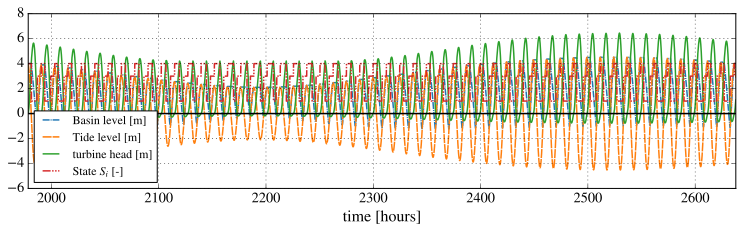

In [64]:
mpl.plot( hours_vec, z_vec, label='Basin level [m]', dashes=(7,1,1,1) )
mpl.plot( hours_vec, ζ_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, h_vec, label='turbine head [m]', dashes=(9,0) )
mpl.plot( hours_vec, FSM_states_vec, label='State $S_i$ [-]' )
mpl.axhline(0, color='k')
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left', fontsize=12)
mpl.grid()
mpl.savefig('TimeSeriesLevels.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesLevels.svg', bbox_inches='tight', pad_inches=0) # Word

# The plots can be zoomed by changing the xlimits (mpl.xlim)

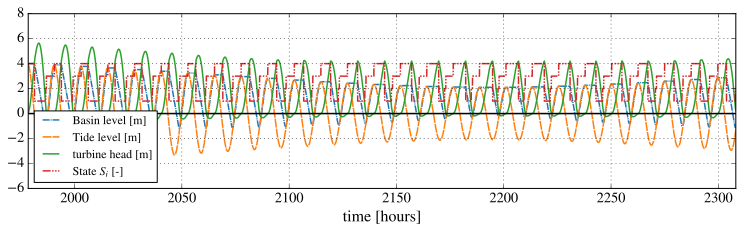

In [65]:
mpl.plot( hours_vec, z_vec, label='Basin level [m]', dashes=(7,1,1,1) )
mpl.plot( hours_vec, ζ_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, h_vec, label='turbine head [m]', dashes=(9,0) )
mpl.plot( hours_vec, FSM_states_vec, label='State $S_i$ [-]' )
mpl.axhline(0, color='k')
mpl.xlim( 3*period_hours, 3.5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left', fontsize=12)
mpl.grid()
mpl.savefig('TimeSeriesLevels_Zoom.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesLevels_Zoom.svg', bbox_inches='tight', pad_inches=0) # Word

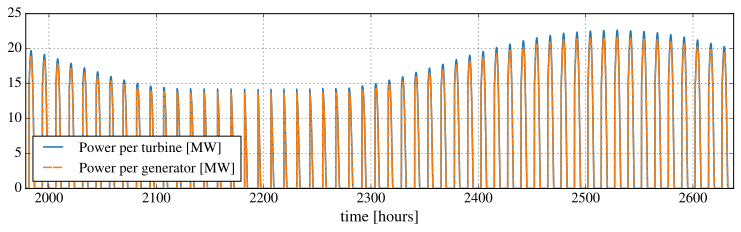

In [66]:
mpl.plot( hours_vec, P_turb_vec/1E6, label='Power per turbine [MW]'  )
mpl.plot( hours_vec, P_gen_vec/1E6, label='Power per generator [MW]', dashes=(9,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid()
mpl.savefig('TimeSeriesPowers.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesPowers.svg', bbox_inches='tight', pad_inches=0) # Word

(1150.0, 1180.0)

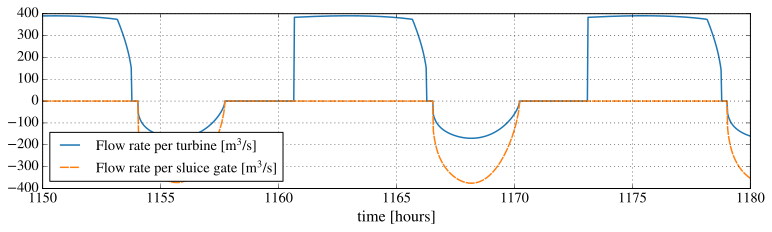

In [67]:
mpl.plot( hours_vec, Q_turb_vec, label='Flow rate per turbine [m$^3$/s]' )
mpl.plot( hours_vec, Q_sluice_vec, label='Flow rate per sluice gate [m$^3$/s]', dashes=(9,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid()
mpl.savefig('TimeSeriesFlowRates.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesFlowRates.svg', bbox_inches='tight', pad_inches=0) # Word
mpl.xlim(1150,1180)

(1150.0, 1180.0)

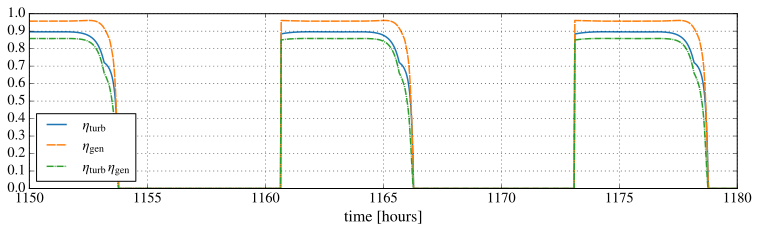

In [68]:
mpl.plot( hours_vec, η_turb_vec, label='$\eta_\mathrm{turb}$' )
mpl.plot( hours_vec, η_gen_vec, label='$\eta_\mathrm{gen}$', dashes=(9,1) )
mpl.plot( hours_vec, η_turb_vec*η_gen_vec, label='$\eta_\mathrm{turb}\,\eta_\mathrm{gen}$', dashes=(7,1,1,1) )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.gca().set_yticks(np.arange( 0, 1.01, 0.1) )
mpl.grid()
mpl.savefig('TimeSeriesEfficiencies.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('TimeSeriesEfficiencies.svg', bbox_inches='tight', pad_inches=0) # Word
mpl.xlim(1150,1180)

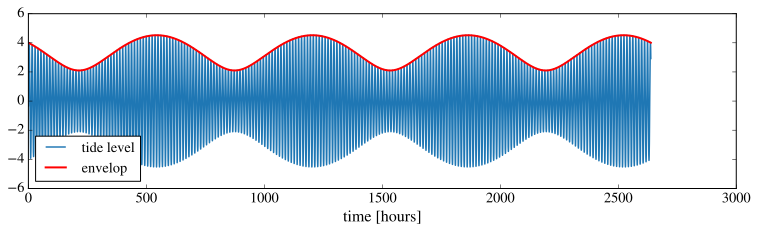

In [69]:
if len( cfg.ω ) == 2:
    X1 = cfg.A[0]
    X2 = cfg.A[1]
    ωm = cfg.ω[0] - cfg.ω[1]
    φm = cfg.φ[0] - cfg.φ[1]
    ev = np.sqrt(X1**2 + X2**2 + 2*X1*X2*np.cos( ωm*time_vec + φm ) )

    mpl.plot( hours_vec, ζ_vec, label="tide level" )
    mpl.plot( hours_vec, ev, 'r-', lw=2, label="envelop" )
    #mpl.xlim( 3*period_hours, 4*period_hours )
    mpl.xlabel( 'time [hours]' )
    mpl.legend(loc='lower left')

    mpl.savefig('TimeSeriesTides.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
    mpl.savefig('TimeSeriesTides.svg', bbox_inches='tight', pad_inches=0) # Word
else:
  print( "No envelop to plot" );

In [73]:
def parametric_analysis( nT, Pgen_rated ):

    cfg = Config()

    cfg.n_turbs = nT
    cfg.Pgen_rated = Pgen_rated

    models = Models( cfg )

    simul = FSM_simulator( cfg.simul_time, cfg.delta_t, cfg.n_SS_vars, cfg.n_SS_outs )

    simul.set_state( 0, models.SX_Hold )
    simul.set_state( 1, models.S1_Generate )
    simul.set_state( 2, models.SX_Hold )
    simul.set_state( 3, models.S3_Fill )
    simul.set_state( 4, models.SX_Hold )

    simul.add_transition( 0, models.T_S0_S1 )
    simul.add_transition( 1, models.T_S1_S2 )
    simul.add_transition( 2, models.T_S2_S3 )
    simul.add_transition( 3, models.T_S3_S4 )
    simul.add_transition( 4, models.T_S4_S1 )

    initial_condition = np.array( (cfg.basin_z0, 0.0, 0.0, 0.0) )

    ( time_vec, FSM_states_vec, SS_vars, SS_outs ) = simul.run_simulator( 0, initial_condition )

    #=================================
    z_vec       = SS_vars[0]
    E_avail_vec = SS_vars[1]
    E_turb_vec  = SS_vars[2]
    E_gen_vec   = SS_vars[3]

    #=================================
    h_vec = SS_outs[0]
    ζ_vec = SS_outs[1]

    Q_turb_vec   = SS_outs[2]
    Q_sluice_vec = SS_outs[3]

    P_avail_vec = SS_outs[4]
    P_turb_vec  = SS_outs[5]
    P_gen_vec   = SS_outs[6]
    η_turb_vec  = SS_outs[7]
    η_gen_vec   = SS_outs[8]


    hours_vec = time_vec / 3600.0
    period_hours = cfg.global_period / 3600.0

    # Number of points of each period. Required to make the mean of last period
    pp = int( cfg.global_period / cfg.delta_t )

    P_turb_max = np.max( P_turb_vec )
    P_turb_mean = np.mean( P_turb_vec[-pp:] )
    P_gen_mean = np.mean( P_gen_vec[-pp:] )
    C_fac = P_gen_mean / models.generator.Pgen_rated

    return C_fac, P_turb_mean, P_turb_max


nT_lst = []
CF_lst = []
TP_lst = []

for nT  in range( 1, 71, 10 ):
    CF, P_turb_mean, P_turb_max = parametric_analysis( nT, 250E6 )

    Pgen_rated = (int(P_turb_max/1E6)+10)*1E6
    CF, P_turb_mean, P_turb_max = parametric_analysis( nT, Pgen_rated )
    nT_lst.append( nT )
    CF_lst.append( CF )
    TP_lst.append( P_turb_mean*nT/1E6 )

    print( "nT = %i, CF = %.3f, Pturb*nT = %.3E, P_turb_max = %.3E, Pgen_rated = %.3E" % ( nT, CF, P_turb_mean*nT, P_turb_max, Pgen_rated ) )

mpl.plot( nT_lst, TP_lst )
mpl.xlabel( "Number of turbines" )
mpl.ylabel( "Total turbine power, $P_\\mathrm{turb} n_\\mathrm{turb}$, [MW]" )

mpl.savefig('PowerAsFunctionNumberTurbines.pdf', bbox_inches='tight', pad_inches=0) # pdflatex
mpl.savefig('PowerAsFunctionNumberTurbines.svg', bbox_inches='tight', pad_inches=0) # Word

AssertionError: n11 small than admissable minimum